In [ ]:
# %pip install pandas

### Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 50)

# Load the dataset
# Make sure the 'customer_churn_mini.json' file is in the '../data/' directory
try:
    df = pd.read_json("/mnt/c/Users/moham/8_churn/data/customer_churn.json", lines=True)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(
        "Error: Dataset not found. Please place 'customer_churn_mini.json' in the 'Data/' folder."
    )

Dataset loaded successfully.


Dataset loaded and preprocessed.


####  Initial Data Inspection

In [2]:
print("Shape of the dataset:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nData types and non-null counts:")
df.info()

Shape of the dataset: (543705, 18)

First 5 rows:


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             543705 non-null  int64  
 1   userId         543705 non-null  object 
 2   sessionId      543705 non-null  int64  
 3   page           543705 non-null  object 
 4   auth           543705 non-null  object 
 5   method         543705 non-null  object 
 6   status         543705 non-null  int64  
 7   level          543705 non-null  object 
 8   itemInSession  543705 non-null  int64  
 9   location       528005 non-null  object 
 10  userAgent      528005 non-null  object 
 11  lastName       528005 non-null  object 
 12  firstName      528005 non-null  object 
 13  registration   528005 non-null  float64
 14  gender         528005 non-null  object 
 15  artist         432877 non-null  object 
 16  song           432877 non-null  object 
 

In [4]:
# To define inactivity, we must know the timeframe of our data.
min_date = df_logged_in["ts"].min()
max_date = df_logged_in["ts"].max()

print(f"Data ranges from: {min_date} to {max_date}")
print(f"Total duration: {(max_date - min_date).days} days")

# We'll define "recent inactivity" based on this. Let's assume a user is inactive
# if their last action was more than 30 days before the last record in the dataset.
INACTIVITY_THRESHOLD = pd.Timedelta(days=30)

Data ranges from: 2018-10-01 00:00:11 to 2018-12-01 00:01:06
Total duration: 61 days


### Identify Logged-Out Users

In [3]:
# Check the 'auth' column to see user status
auth_counts = df["auth"].value_counts()
print(auth_counts)

# We are only interested in logged-in users for churn prediction.
# Filter out events from guests or logged-out sessions.
df_logged_in = df[df["auth"] == "Logged In"].copy()
print(f"\nFiltered dataset to {df_logged_in.shape[0]} events from logged-in users.")

auth
Logged In     527906
Logged Out     15606
Cancelled         99
Guest             94
Name: count, dtype: int64

Filtered dataset to 527906 events from logged-in users.


### Define the Churn Label

In [4]:
# The 'page' column contains the actions users take.
print("Exploring the 'page' column to define churn:")
print(df_logged_in["page"].value_counts())

# A user is defined as "churned" if they have visited the 'Cancellation Confirmation' page.
churn_users = df_logged_in[df_logged_in["page"] == "Cancellation Confirmation"][
    "userId"
].unique()
print(f"\nIdentified {len(churn_users)} unique users who have churned.")

# Create a churn label column
df_logged_in["churn"] = df_logged_in["userId"].isin(churn_users).astype(int)

Exploring the 'page' column to define churn:
page
NextSong            432877
Thumbs Up            23826
Home                 19089
Add to Playlist      12349
Add Friend            8087
Roll Advert           7773
Logout                5990
Thumbs Down           4911
Downgrade             3811
Settings              2964
Help                  2644
About                 1026
Upgrade                968
Save Settings          585
Error                  503
Submit Upgrade         287
Submit Downgrade       117
Cancel                  99
Name: count, dtype: int64

Identified 0 unique users who have churned.


###  Analyze Churn Distribution

Churn distribution at user level:
churn
0    448
Name: count, dtype: int64

Overall churn rate: 0.00%


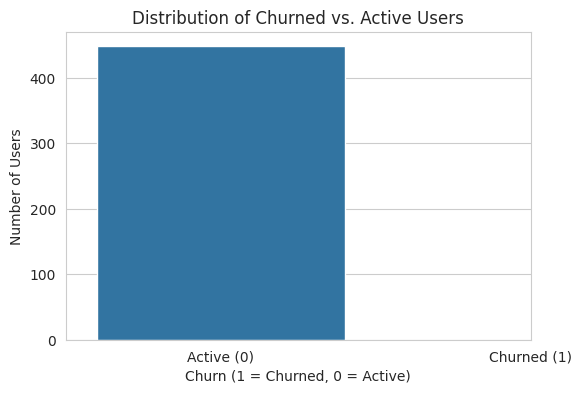

In [6]:
# Analyze churn at the user level
user_level_churn = df_logged_in[["userId", "churn"]].drop_duplicates()
churn_distribution = user_level_churn["churn"].value_counts()

# Safely get the churn rate. Use .get(1, 0.0), which returns 0.0 if key '1' is not found.
churn_rate = user_level_churn["churn"].value_counts(normalize=True).get(1, 0.0)

print("Churn distribution at user level:")
print(churn_distribution)
print(f"\nOverall churn rate: {churn_rate:.2%}")

# Visualize the imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x="churn", data=user_level_churn)
plt.title("Distribution of Churned vs. Active Users")
plt.xlabel("Churn (1 = Churned, 0 = Active)")
plt.ylabel("Number of Users")
# Ensure the x-axis always shows labels for both potential outcomes
plt.xticks(ticks=[0, 1], labels=["Active (0)", "Churned (1)"])
plt.show()

### Explore User Demographics

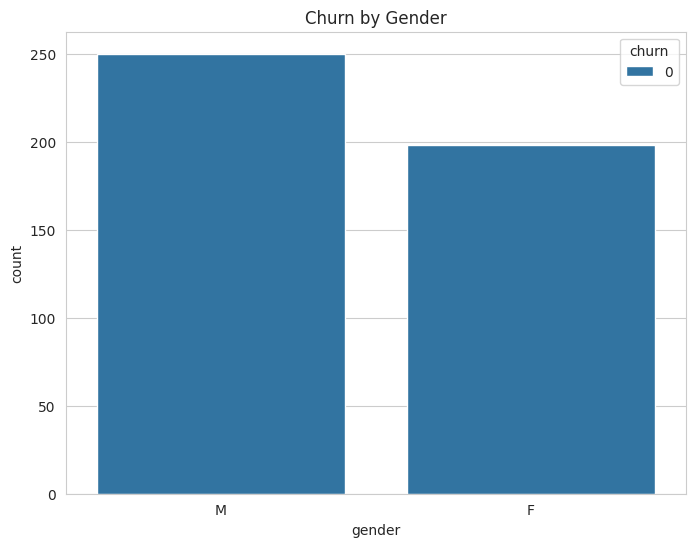

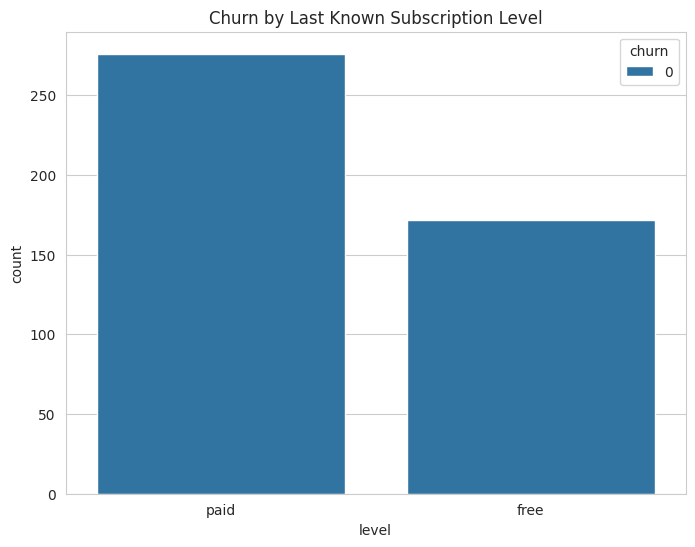

In [7]:
# Look at gender distribution between churned and active users
user_demographics = df_logged_in[["userId", "gender", "churn"]].drop_duplicates()

plt.figure(figsize=(8, 6))
sns.countplot(x="gender", hue="churn", data=user_demographics)
plt.title("Churn by Gender")
plt.show()

# Look at subscription level (paid vs. free)
user_level_status = df_logged_in.groupby("userId")["level"].last().reset_index()
user_level_status = pd.merge(user_level_status, user_level_churn, on="userId")

plt.figure(figsize=(8, 6))
sns.countplot(x="level", hue="churn", data=user_level_status)
plt.title("Churn by Last Known Subscription Level")
plt.show()

### Explore User Engagement (Song Plays)

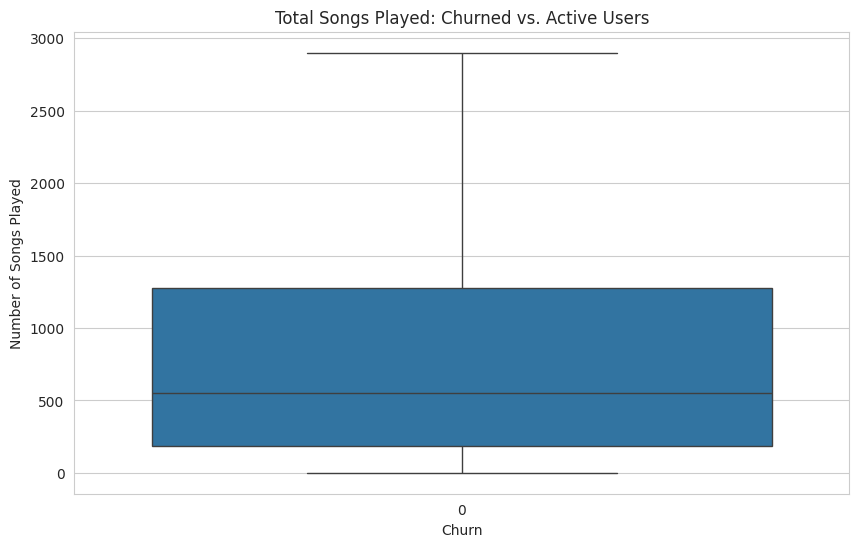

Median songs played by active users: 550.0
Median songs played by churned users: nan


In [8]:
# Compare total songs played for churned vs. active users
user_song_counts = (
    df_logged_in[df_logged_in["page"] == "NextSong"]
    .groupby("userId")
    .size()
    .reset_index(name="song_count")
)
user_song_counts = pd.merge(user_song_counts, user_level_churn, on="userId")

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="churn", y="song_count", data=user_song_counts, showfliers=False
)  # remove outliers for better viz
plt.title("Total Songs Played: Churned vs. Active Users")
plt.xlabel("Churn")
plt.ylabel("Number of Songs Played")
plt.show()

print(
    "Median songs played by active users:",
    user_song_counts[user_song_counts["churn"] == 0]["song_count"].median(),
)
print(
    "Median songs played by churned users:",
    user_song_counts[user_song_counts["churn"] == 1]["song_count"].median(),
)

### Explore User Tenure

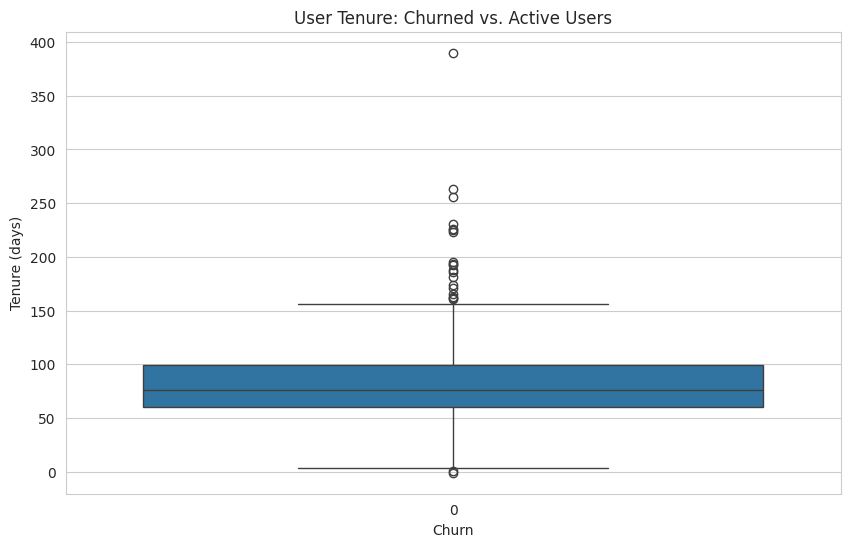

Median tenure for active users: 76.0
Median tenure for churned users: nan


In [9]:
# Convert timestamp columns to datetime
df_logged_in["ts"] = pd.to_datetime(df_logged_in["ts"], unit="ms")
df_logged_in["registration"] = pd.to_datetime(df_logged_in["registration"], unit="ms")

# Calculate tenure for each user
user_tenure = (
    df_logged_in.groupby("userId")
    .agg(registration_date=("registration", "first"), last_seen_date=("ts", "max"))
    .reset_index()
)
user_tenure["tenure_days"] = (
    user_tenure["last_seen_date"] - user_tenure["registration_date"]
).dt.days

user_tenure = pd.merge(user_tenure, user_level_churn, on="userId")

# Visualize tenure distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x="churn", y="tenure_days", data=user_tenure)
plt.title("User Tenure: Churned vs. Active Users")
plt.xlabel("Churn")
plt.ylabel("Tenure (days)")
plt.show()

print(
    "Median tenure for active users:",
    user_tenure[user_tenure["churn"] == 0]["tenure_days"].median(),
)
print(
    "Median tenure for churned users:",
    user_tenure[user_tenure["churn"] == 1]["tenure_days"].median(),
)

In [ ]:
# # File paths
# file1 = "/mnt/c/Users/moham/8_churn/Data/customer_churn.json"
# file2 = "/mnt/c/Users/moham/8_churn/Data/customer_churn_mini.json"

In [ ]:
# # Read JSON files into DataFrames
# df_full = pd.read_json(file1, lines=True)   # Use lines=True if it's JSONL format (one JSON per line)
# df_mini = pd.read_json(file2, lines=True)

In [ ]:
# # Show basic info
# print("Full Dataset Shape:", df_full.shape)
# print("Mini Dataset Shape:", df_mini.shape)

Full Dataset Shape: (543705, 18)
Mini Dataset Shape: (286500, 18)
